##### Introduction


#### PostgreSQL + Python (psycopg2)

In this notebook, we’ll learn to interact with a PostgreSQL database using Python’s `psycopg2` library.

We'll:

- Connect to PostgreSQL
- Create and populate tables (`customers`, `orders`, `products`)
- Perform CRUD operations
- Execute joins and aggregations
- Export query results to Pandas

This mirrors what we did in SQLite but for a production-grade relational database.


##### 2. Setup


In [3]:
import psycopg2
import pandas as pd

# database connection details
db_config = {
    "host": "localhost",
    "database": "python",
    "user": "postgres",
    "password": "2013@Wewe",
    "port": 5432
}

##### 3. Create a database connection


In [4]:
# connect safely using context manager
try:
    with psycopg2.connect(**db_config) as conn:
        with conn.cursor() as cur:
            cur.execute("SELECT version();")
            print("Connected to :",cur.fetchone())
except Exception as e:
    print("Connection Failed ",e)

Connected to : ('PostgreSQL 17.5 on x86_64-windows, compiled by msvc-19.44.35209, 64-bit',)


##### 4. Create realated tables


In [5]:
with psycopg2.connect(**db_config) as conn:
    with conn.cursor() as cur:
        cur.execute("""
        CREATE TABLE IF NOT EXISTS customers(
            customer_id SERIAL PRIMARY KEY,
            first_name VARCHAR(100),
            last_name VARCHAR(100),
            email VARCHAR(150) UNIQUE,
            city VARCHAR(100),
            region VARCHAR(100),
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );
        """)

        cur.execute("""
        CREATE TABLE IF NOT EXISTS products(
            product_id SERIAL PRIMARY KEY,
            product_name VARCHAR(150),
            category VARCHAR(100),
            price NUMERIC(10,2)
        );
        """)

        cur.execute("""
        CREATE TABLE IF NOT EXISTS orders(
            order_id SERIAL PRIMARY KEY,
            customer_id INT REFERENCES customers(customer_id),
            product_id INT REFERENCES products(product_id),
            order_date DATE,
            quantity INT CHECK(quantity > 0),
            status VARCHAR(50)
        );
        """)

        conn.commit()
print("Tables Created successifully")

Tables Created successifully


##### 5. Insert Sample data


In [6]:
customers = [
   ("Daniel", "Masila", "daniel@example.com", "Nairobi", "Central"),
    ("Jane", "Mwangi", "jane@example.com", "Nakuru", "Rift Valley"),
    ("John", "Otieno", "john@example.com", "Kisumu", "Western")
]

products = [
    ("Wireless Mouse", "Accessories", 1200),
    ("Laptop Stand", "Accessories", 3500),
    ("HDMI Cable", "Cables", 800),
    ("Monitor 24 inch", "Electronics", 16000),
    ("Office Chair", "Furniture", 18000)
]

orders = [
    (1, 1, "2025-10-01", 2, "Delivered"),
    (2, 2, "2025-10-03", 1, "Delivered"),
    (3, 3, "2025-10-04", 3, "Pending"),
    (1, 4, "2025-10-05", 1, "Shipped"),
    (2, 5, "2025-10-06", 1, "Processing")
]

## insert the data
with psycopg2.connect(**db_config) as conn:
    with conn.cursor() as cur:
        cur.executemany(
            """
            INSERT INTO customers (first_name,last_name,email,city,region)
            VALUES(%s,%s,%s,%s,%s)
            ON CONFLICT (email) DO NOTHING
            """ , customers
        )
        
        cur.executemany(
            """
            INSERT INTO products(product_name,category,price)
            VALUES (%s,%s,%s)
            ON CONFLICT DO NOTHING
            """ , products
        )
        
        cur.executemany(
            """
            INSERT INTO orders(customer_id,product_id,order_date,quantity,status)
            VALUES (%s,%s,%s,%s,%s)
            """, orders
        )
print("Data inserted Successifully")

Data inserted Successifully


##### 6. Read data


In [7]:
with psycopg2.connect(**db_config) as conn:
    with conn.cursor() as cur:
        data =cur.execute("SELECT first_name, email FROM customers")
        for row in cur.fetchall():
            print(row)

('Daniel', 'daniel@example.com')
('Jane', 'jane@example.com')
('John', 'john@example.com')


##### 7. Joins and Aggregation


In [8]:
query = """
SELECT c.first_name,c.last_name,c.city,p.product_name,
    o.quantity,p.price,
    (o.quantity * p.price) As total_amount
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
    JOIN products p ON o.product_id = p.product_id;
"""
with psycopg2.connect(**db_config) as conn:
    df= pd.read_sql_query(query,conn)
df.head()
        


C:\Users\dante\AppData\Local\Temp\ipykernel_14708\3851728996.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df= pd.read_sql_query(query,conn)


,first_name,last_name,city,product_name,quantity,price,total_amount
0,Daniel,Masila,Nairobi,Wireless Mouse,2,1200.0,2400.0
1,Jane,Mwangi,Nakuru,Laptop Stand,1,3500.0,3500.0
2,John,Otieno,Kisumu,HDMI Cable,3,800.0,2400.0
3,Daniel,Masila,Nairobi,Monitor 24 inch,1,16000.0,16000.0
4,Jane,Mwangi,Nakuru,Office Chair,1,18000.0,18000.0


##### 8. Analytical Queries


C:\Users\dante\AppData\Local\Temp\ipykernel_14708\2201001895.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_by_category = pd.read_sql_query(query,conn)


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Furniture'),
  Text(1, 0, 'Electronics'),
  Text(2, 0, 'Accessories'),
  Text(3, 0, 'Cables')])

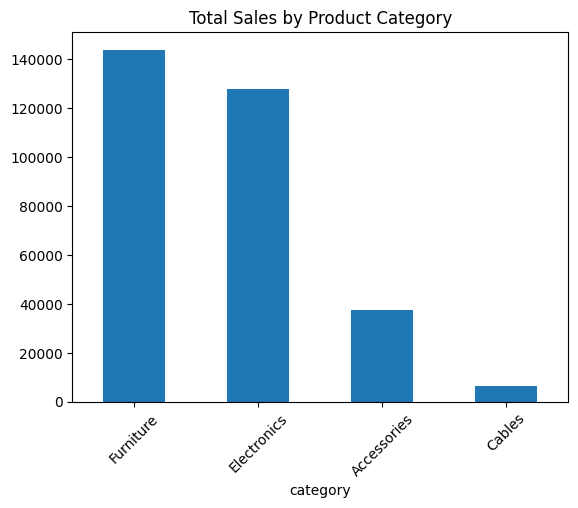

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

query = """
SELECT p.category,SUM(o.quantity * p.price) AS total_sales
FROM products p
JOIN orders o ON p.product_id = p.product_id
GROUP BY p.category
ORDER BY total_sales DESC
"""

with psycopg2.connect(**db_config) as conn:
    sales_by_category = pd.read_sql_query(query,conn)
    
sales_by_category.plot(kind='bar',x='category',y='total_sales',
                       legend=False,title="Total Sales by Product Category")
plt.xticks(rotation =45)

using plotly


In [10]:
fig = px.bar(sales_by_category,
             x='category',
             y='total_sales',
             color='category',
            text='total_sales',
            title = "Sales By category"
            
)
fig.update_layout(width=1000,height=400,showlegend = False)
fig.show()

##### 9. Update and Delete


In [11]:
with psycopg2.connect(**db_config) as conn:
    with conn.cursor() as cur:
        cur.execute("UPDATE orders SET status = 'Delivered' WHERE status = 'Pending';")
        cur.execute("DELETE FROM orders WHERE status ='Cancelled';")

print("Orders updated and cleaned up")

Orders updated and cleaned up


##### 10. Export To csv


In [11]:
with psycopg2.connect(**db_config) as conn:
    df = pd.read_sql_query("SELECT * FROM orders;",conn)
    
df.to_csv('pg_orders_exports.csv',index=False)
print("Exported to pg_orders_export.csv")

Exported to pg_orders_export.csv


C:\Users\dante\AppData\Local\Temp\ipykernel_7040\2721312648.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



##### 11 . Summary


We learned how to:

- Connect to PostgreSQL with `psycopg2`
- Use context managers (`with`) for safe operations
- Create related tables (`customers`, `products`, `orders`)
- Perform CRUD and join queries
- Execute aggregations and visualizations
- Export query results into Pandas

Next: Use **SQLAlchemy** to simplify and abstract database interactions.
